In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any, Union

CSV_DATA = Path().cwd().parent.parent / "data/2_loaded"

In [2]:
df = pd.read_csv(CSV_DATA/'summary/ride_summary_good.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['year'] = df['start_date'].dt.year
df['month'] = df['start_date'].dt.month
df['month_name'] = df['start_date'].dt.month_name()
df['start_time'] = pd.to_timedelta(df['start_time'])
df['end_time'] = pd.to_timedelta(df['end_time'])

## Handle categorical variables
month_order = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
df['month_name'] = pd.Categorical(df['month_name'] , categories=month_order.keys(), ordered=True)

In [3]:
power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h','best_power_2h']

In [4]:
import re
def get_power_curves(df_summary:pd.DataFrame, ride_id_subset:list[str]=None) -> pd.DataFrame:
    # Subset the df_summary columns and filter for the relevant ride_ids
    cols_of_interest = ['ride_id', 'start_date','year','month','month_name', 'total_distance_mi','total_ascent_ft','avg_power']
    power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h', 'best_power_2h']
    cols_of_interest += power_cols
    if ride_id_subset is None: ride_id_subset = df['ride_id'].values # if not specified, all rides will be used
    df_rides = df_summary.copy().loc[df_summary['ride_id'].isin(ride_id_subset), cols_of_interest]

    # Create a mapping from power column names back to axis labels and values
    power_col_map = get_power_column_mapping(power_cols)

    # For each ride, plot its power curve
    df_powers = []
    for _, row in df_rides.iterrows():
        data = [{'duration':power_col_map[col]['duration'], 'duration_label':power_col_map[col]['label'], 'best_power':row[col]} for col in power_cols]
        df_pwr = pd.DataFrame(data)
        df_pwr['duration_label'] = pd.Categorical(df_pwr['duration_label'], categories=[x.replace('best_power_','') for x in power_cols], ordered=True)
        df_pwr['ride_id']=row['ride_id']
        df_pwr['year']=row['year']
        df_pwr['month']=row['month']
        df_pwr['month_name']=row['month_name']
        df_pwr = df_pwr[['ride_id','year','month','month_name','duration','duration_label','best_power']]
        df_powers.append(df_pwr)

    return pd.concat(df_powers, ignore_index=True)

def get_power_column_mapping(power_cols:list[str]) -> dict:
    # Create a mapping from power column names back to axis labels and values
    pattern = r'best_power_([\d]+)([smh])'
    seconds_map = {'s':1, 'm':60, 'h':60*60}
    power_col_map = dict()
    for col in power_cols:
        matched = re.match(pattern, col)
        if matched is not None:
            value, unit = matched.groups()
            power_col_map[col] = {'label':value+unit,'duration':int(value)*seconds_map[unit]}
    return power_col_map

def get_top_cyclists_power_curve() -> pd.DataFrame:
    power_col_map = get_power_column_mapping(power_cols)
    # top 1% of cyclists, ref: https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare
    top_cyclist_powers = {'best_power_4s':1650, 'best_power_5s':1500,'best_power_10s':1375, 'best_power_20s':1200, 'best_power_30s':1000, 'best_power_1m':775,
                        'best_power_2m':600, 'best_power_3m':560, 'best_power_4m':535, 'best_power_5m':510,
                        'best_power_6m':500, 'best_power_10m':490, 'best_power_20m':460, 'best_power_30m':420,
                        'best_power_40m':375, 'best_power_1h':360}
    data = [{'duration':power_col_map[col]['duration'], 'best_power':top_cyclist_powers[col]} for col in top_cyclist_powers.keys()]
    df_pwr_top = pd.DataFrame(data)
    return df_pwr_top

In [5]:
def create_power_curve_aggregation(df_pwrs:pd.DataFrame, groupby:list[str], agg_func:str='max') -> pd.DataFrame:
    df_agg = df_pwrs[groupby+['duration','duration_label','best_power']].groupby(groupby+['duration','duration_label']).agg(agg_func).reset_index()
    return df_agg

def create_power_curve_pivot_table(df_pwrs:pd.DataFrame, index_on:str='duration_label', columns_by:str=None, 
                                   column_order:list[Union[float,int,str]]=None) -> pd.DataFrame:
    df_pwrs = df_pwrs.copy()
    if columns_by is None: 
        # if no columns_by is specified, then use the index # of a row in df_pwrs
        df_pwrs['row_num'] = list(range(df_pwrs.shape[0]))
        columns_by = 'row_num'
    

    df_pwr_pivot = pd.pivot_table(df_pwrs, values='best_power', columns=columns_by, index=index_on)

    if column_order is not None:
        # Make sure that each column in column_order exists before re-arranging the pivoted dataframe
        for col in column_order:
            if col not in df_pwr_pivot.columns:
                df_pwr_pivot[col]=0.0
        # Re-arrange the column order of the pivoted dataframe
        df_pwr_pivot = df_pwr_pivot.loc[:,column_order] 
    
    # Fill missing values with 0.0
    # NOTE: this implies that after this time duration where 'best_power' is zero, the rider stopped and did not do any further work
    # The rolling window calculation for the power curve requires the entire window to have data.
    # |--> for example: a 1.5 hour ride cannot use that 1.5 hour of data to take the mean across a 2 hour hypothetical window...
    df_pwr_pivot = df_pwr_pivot.fillna(0.0)
    return df_pwr_pivot

In [6]:
df_pwrs = get_power_curves(df_summary=df)

In [7]:
#df_pwrs_by_year = df_pwrs[['year','duration','duration_label','best_power']].groupby(['year','duration','duration_label',]).max().reset_index()

In [8]:
df_by_year_aggmax = create_power_curve_aggregation(df_pwrs, groupby=['year'], agg_func='max')
df_by_year_aggavg = create_power_curve_aggregation(df_pwrs, groupby=['year'], agg_func='mean')
df_pivot_by_year_aggmax = create_power_curve_pivot_table(df_by_year_aggmax, columns_by='year')
df_pivot_by_year_aggavg = create_power_curve_pivot_table(df_by_year_aggavg, columns_by='year')

/tmp/ipykernel_20610/254460710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_pwrs[groupby+['duration','duration_label','best_power']].groupby(groupby+['duration','duration_label']).agg(agg_func).reset_index()
/tmp/ipykernel_20610/254460710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_pwrs[groupby+['duration','duration_label','best_power']].groupby(groupby+['duration','duration_label']).agg(agg_func).reset_index()


In [9]:
df_pwrs_2024 = df_pwrs.loc[df_pwrs['year']==2024,:]
df_by_month24_aggmax = create_power_curve_aggregation(df_pwrs_2024, groupby=['month_name'], agg_func='max')
df_by_month24_aggavg = create_power_curve_aggregation(df_pwrs_2024, groupby=['month_name'], agg_func='mean')
df_pivot_by_month24_aggmax = create_power_curve_pivot_table(df_by_month24_aggmax, columns_by='month_name', column_order=month_order.keys())
df_pivot_by_month24_aggavg = create_power_curve_pivot_table(df_by_month24_aggavg, columns_by='month_name', column_order=month_order.keys())

/tmp/ipykernel_20610/254460710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_pwrs[groupby+['duration','duration_label','best_power']].groupby(groupby+['duration','duration_label']).agg(agg_func).reset_index()
/tmp/ipykernel_20610/254460710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_pwrs[groupby+['duration','duration_label','best_power']].groupby(groupby+['duration','duration_label']).agg(agg_func).reset_index()


In [10]:
df_pwrs_2020 = df_pwrs.loc[df_pwrs['year']==2020,:]
df_by_month20_aggmax = create_power_curve_aggregation(df_pwrs_2020, groupby=['month_name'], agg_func='max')
df_by_month20_aggavg = create_power_curve_aggregation(df_pwrs_2020, groupby=['month_name'], agg_func='mean')
df_pivot_by_month20_aggmax = create_power_curve_pivot_table(df_by_month20_aggmax, columns_by='month_name', column_order=month_order.keys())
df_pivot_by_month20_aggavg = create_power_curve_pivot_table(df_by_month20_aggavg, columns_by='month_name', column_order=month_order.keys())

/tmp/ipykernel_20610/254460710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_pwrs[groupby+['duration','duration_label','best_power']].groupby(groupby+['duration','duration_label']).agg(agg_func).reset_index()
/tmp/ipykernel_20610/254460710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_pwrs[groupby+['duration','duration_label','best_power']].groupby(groupby+['duration','duration_label']).agg(agg_func).reset_index()


### Progression of Individual Rides

In [40]:
df_pwrs_2024 = df_pwrs.loc[df_pwrs['year']==2024,:].reset_index()
df_pwrs_2024['ride_num'] = df_pwrs_2024['ride_id'].replace({ride_id:k for k,ride_id in enumerate(df_pwrs_2024.groupby('ride_id').groups.keys())})
df_pivot_by_rides24_aggmax = create_power_curve_pivot_table(df_pwrs_2024, columns_by='ride_num')

In [41]:
df_pwrs_2023 = df_pwrs.loc[df_pwrs['year']==2023,:].reset_index()
df_pwrs_2023['ride_num'] = df_pwrs_2023['ride_id'].replace({ride_id:k for k,ride_id in enumerate(df_pwrs_2023.groupby('ride_id').groups.keys())})
df_pivot_by_rides23_aggmax = create_power_curve_pivot_table(df_pwrs_2023, columns_by='ride_num')

In [42]:
df_pwrs_2022 = df_pwrs.loc[df_pwrs['year']==2022,:].reset_index()
df_pwrs_2022['ride_num'] = df_pwrs_2022['ride_id'].replace({ride_id:k for k,ride_id in enumerate(df_pwrs_2022.groupby('ride_id').groups.keys())})
df_pivot_by_rides22_aggmax = create_power_curve_pivot_table(df_pwrs_2022, columns_by='ride_num')

In [43]:
df_pwrs_2021 = df_pwrs.loc[df_pwrs['year']==2021,:].reset_index()
df_pwrs_2021['ride_num'] = df_pwrs_2021['ride_id'].replace({ride_id:k for k,ride_id in enumerate(df_pwrs_2021.groupby('ride_id').groups.keys())})
df_pivot_by_rides21_aggmax = create_power_curve_pivot_table(df_pwrs_2021, columns_by='ride_num')

In [44]:
df_pwrs_2020 = df_pwrs.loc[df_pwrs['year']==2020,:].reset_index()
df_pwrs_2020['ride_num'] = df_pwrs_2020['ride_id'].replace({ride_id:k for k,ride_id in enumerate(df_pwrs_2020.groupby('ride_id').groups.keys())})
df_pivot_by_rides20_aggmax = create_power_curve_pivot_table(df_pwrs_2020, columns_by='ride_num')

# Plotting Curves as Heatmaps

In [11]:
def plot_pivoted_power_curve_heatmap(df_pivot:pd.DataFrame, figsize:tuple[float,float]=(5,5), log_colors:bool=True,
                                     title:str=None, xlabel:str=None, xlabel_rot:float=75):
    df_pivot_log = df_pivot.apply(lambda x: np.log10(1+x))
    if log_colors:
        df = df_pivot_log
        vmin = np.log10(50) #log(Watts)
    else:
        df = df_pivot
        vmin = 0.0 # Watts
    _ = plt.figure(figsize=figsize)
    _ = sns.heatmap(df, square=True, vmin=vmin,)
    if title is None: title='Power Curve Heatmap'
    if xlabel is None: xlabel='Index'
    _ = plt.xlabel(xlabel, fontsize=14)
    _ = plt.ylabel('Effort Duration', fontsize=14)
    _ = plt.title(title, fontsize=18)
    _ = plt.xticks(rotation=xlabel_rot)


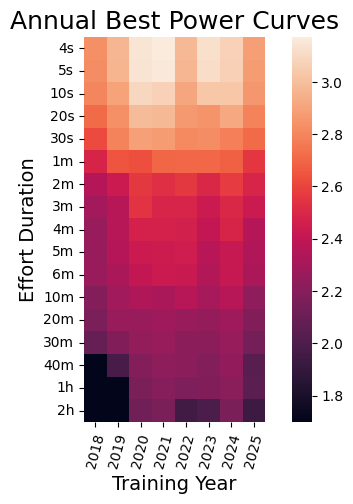

In [12]:
plot_pivoted_power_curve_heatmap(df_pivot_by_year_aggmax, figsize=(7,5), xlabel_rot=90-15, 
                                 title='Annual Best Power Curves', xlabel='Training Year', log_colors=True)

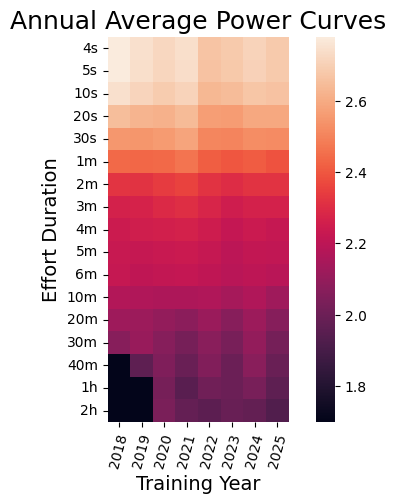

In [13]:
plot_pivoted_power_curve_heatmap(df_pivot_by_year_aggavg, figsize=(7,5), xlabel_rot=90-15, 
                                 title='Annual Average Power Curves', xlabel='Training Year', log_colors=True)

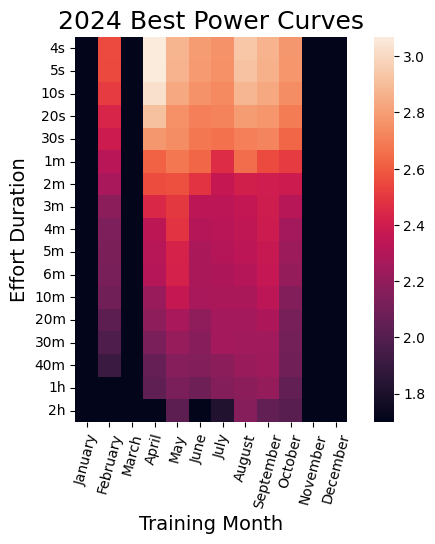

In [14]:
plot_pivoted_power_curve_heatmap(df_pivot_by_month24_aggmax, figsize=(7,5), xlabel_rot=90-15, 
                                 title='2024 Best Power Curves', xlabel='Training Month', log_colors=True)

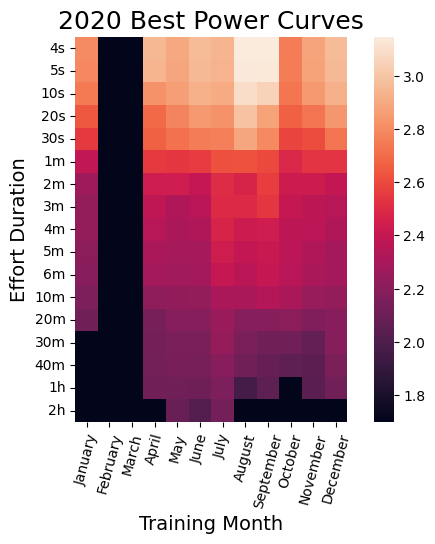

In [15]:
plot_pivoted_power_curve_heatmap(df_pivot_by_month20_aggmax, figsize=(7,5), xlabel_rot=90-15, 
                                 title='2020 Best Power Curves', xlabel='Training Month', log_colors=True)

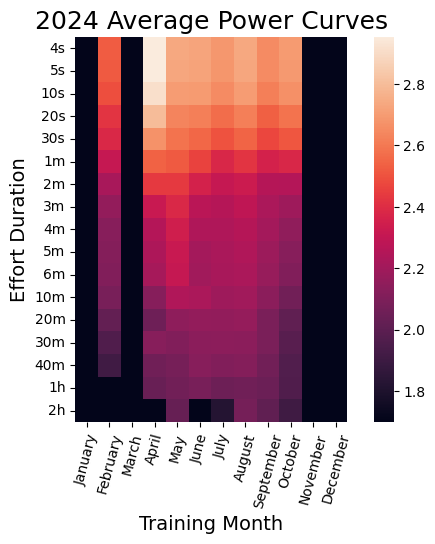

In [16]:
plot_pivoted_power_curve_heatmap(df_pivot_by_month24_aggavg, figsize=(7,5), xlabel_rot=90-15, 
                                 title='2024 Average Power Curves', xlabel='Training Month', log_colors=True)

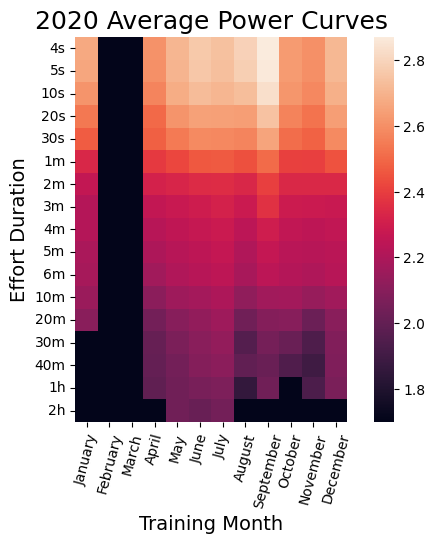

In [17]:
plot_pivoted_power_curve_heatmap(df_pivot_by_month20_aggavg, figsize=(7,5), xlabel_rot=90-15, 
                                 title='2020 Average Power Curves', xlabel='Training Month', log_colors=True)

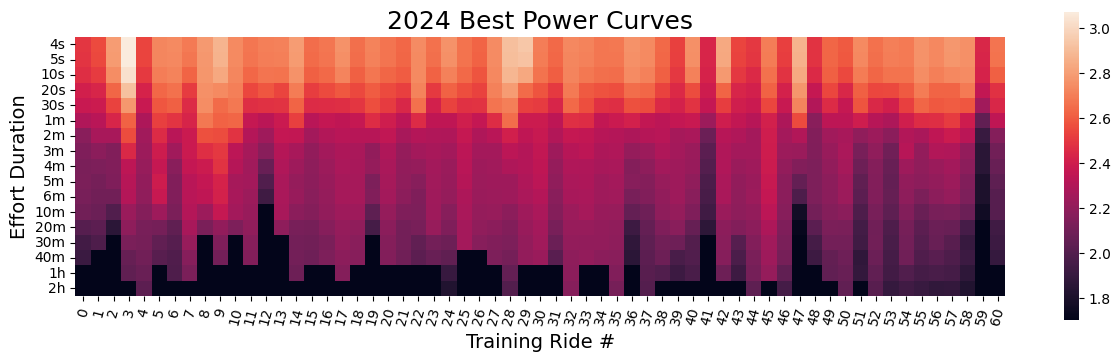

In [36]:
plot_pivoted_power_curve_heatmap(df_pivot_by_rides24_aggmax, figsize=(15,4), xlabel_rot=90-15, 
                                 title='2024 Best Power Curves', xlabel='Training Ride #', log_colors=True)

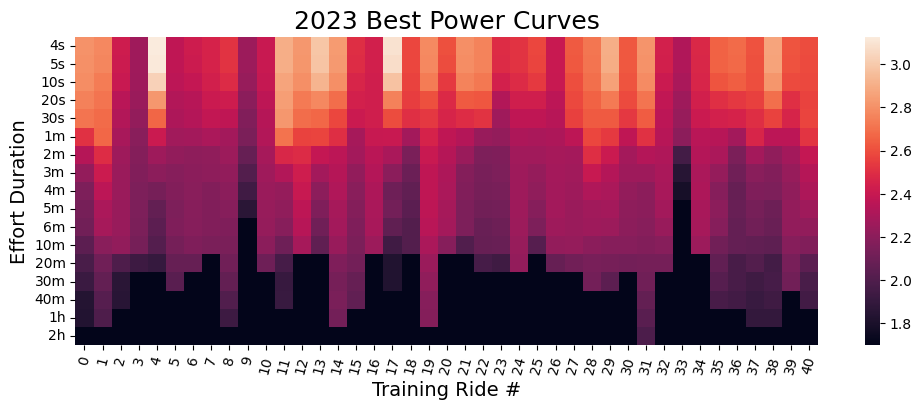

In [46]:
plot_pivoted_power_curve_heatmap(df_pivot_by_rides23_aggmax, figsize=(12,4), xlabel_rot=90-15, 
                                 title='2023 Best Power Curves', xlabel='Training Ride #', log_colors=True)

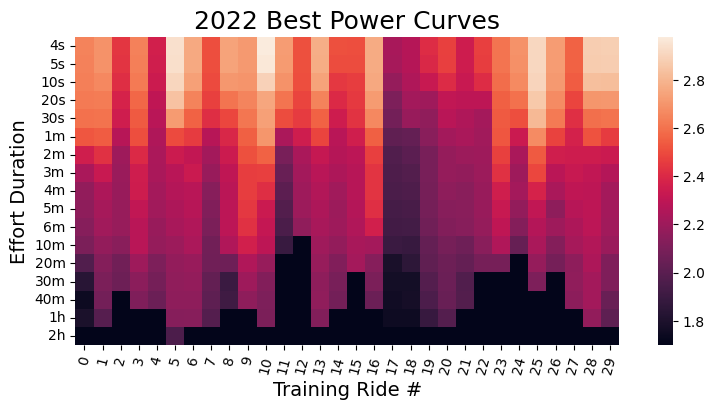

In [48]:
plot_pivoted_power_curve_heatmap(df_pivot_by_rides22_aggmax, figsize=(10,4), xlabel_rot=90-15, 
                                 title='2022 Best Power Curves', xlabel='Training Ride #', log_colors=True)

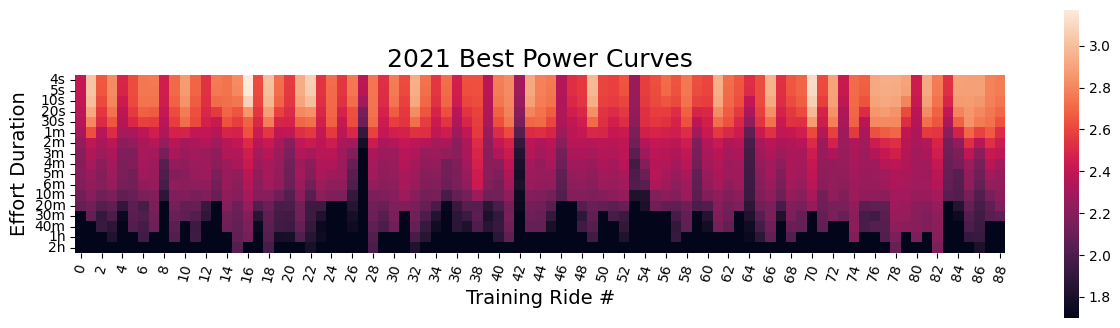

In [50]:
plot_pivoted_power_curve_heatmap(df_pivot_by_rides21_aggmax, figsize=(15,4), xlabel_rot=90-15, 
                                 title='2021 Best Power Curves', xlabel='Training Ride #', log_colors=True)

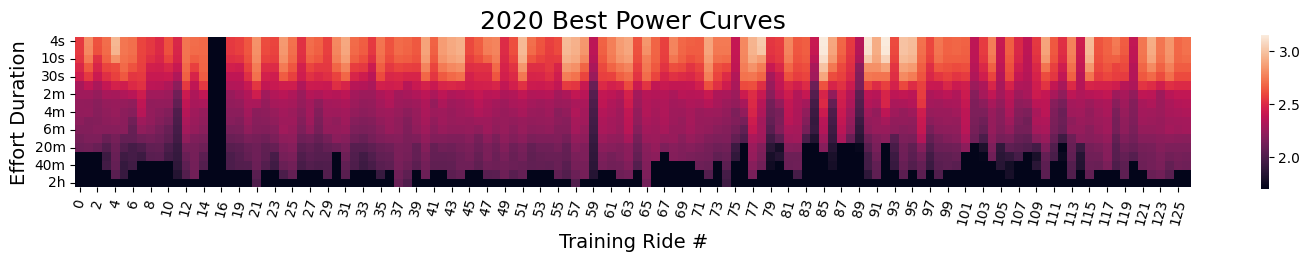

In [39]:
plot_pivoted_power_curve_heatmap(df_pivot_by_rides20_aggmax, figsize=(18,2), xlabel_rot=90-15, 
                                 title='2020 Best Power Curves', xlabel='Training Ride #', log_colors=True)